# Surveillance du COVID_19 pendant le deconfinement en France

## Origine des données
- nb hospitalisation, retour à domicile et décès quotidien sur le COVID19 sur le site data.gouv.fr
- nb habitant par département

In [1]:
from matplotlib import pyplot
import matplotlib
import math
import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn import datasets
import numpy as np
from scipy import stats
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import datetime
# Importation des librairies pour l'analyse des composantes principales
from sklearn import datasets
from sklearn import decomposition
## Importation des données sous forme de dataframe ##
DonneesHosp = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7',sep = ';')
DonneesDep = pd.read_csv('Donnees\Population_departement.csv',sep = ';')
DonneesHosp = DonneesHosp.dropna(how = 'any') # suppression des lignes avec NaN

## Traitement des données

In [2]:
# filtrage des lignes uniquement avec la somme homme et femme
# Lien avec les données département
Donneesmixte = DonneesHosp[DonneesHosp['sexe']==0]
# suppression colonne sexe et reanimation 
del Donneesmixte['sexe']
del Donneesmixte['rea']
# tri les valeurs par departement et jour
Dj = Donneesmixte.sort_values(by = ['dep', 'jour']) 
# Remise en forme du numero de département sur 2 chiffres minimum (0x)
for i in range(len(DonneesDep)-1): # Parcours des lignes dans l'ordre département + jour
    if len(DonneesDep.loc[DonneesDep.index[i], 'CODDEP']) == 1:
        DonneesDep.loc[DonneesDep.index[i], 'CODDEP'] = '0' + DonneesDep.loc[DonneesDep.index[i], 'CODDEP']
# Jointure sur le département pour récupérer le nombre d'habitant (PTOT)
Dj = pd.merge(Dj, DonneesDep, left_on = ['dep'], right_on = ['CODDEP'])
# Suppression de colonne
del Dj['CODDEP']
del Dj['NBARR']
del Dj['NBCAN']
del Dj['PMUN']

In [3]:
# Calcul pour la France entière = somme des départements
for j in Dj[Dj['dep']== '01'].itertuples(): # itération sur tous les jours
    ligne = len(Dj) # ajoute une ligne à la fin
    Dj.loc[ligne,['dep']] = '999'
    Dj.loc[ligne,['jour']] = j.jour
    Dj.loc[ligne,['DEP']] = 'France'
    Dj.loc[ligne,['hosp']] =  Dj[Dj['jour'] == j.jour]['hosp'].sum()  
    Dj.loc[ligne,['rad']] =  Dj[Dj['jour'] == j.jour]['rad'].sum()
    Dj.loc[ligne,['dc']] =  Dj[Dj['jour'] == j.jour]['dc'].sum()
    Dj.loc[ligne,['NBCOM']] =  Dj[Dj['jour'] == j.jour]['NBCOM'].sum()
    Dj.loc[ligne,['PTOT']] =  Dj[Dj['jour'] == j.jour]['PTOT'].sum()
Dj = Dj.reset_index(drop = True) # réindexe

### Calcul des indicateurs par département
- entrées en hospitalisation
- sorties en hospitalisation : guérison et décès
- taux d'hospitalisation : rapport du nombre d'hospitalisation pour 100 000 habitant (Thosp)
- taux de reproduction : rapport du nombre d'entrées pour 100 hospitalisations (Treprod)
- taux de reproduction lissé : filtre du 1er ordre avec une constante de temps de 3 jours (Treprodmoy)

In [4]:
# Initialisation de colonne de colonnnes
Dj['Entree'] = 0 # Colonne des entrées en hospitalisation
Dj['Sortie'] = 0 # Colonne des sorties en hospitalisation
Dj['Thosp'] = 0 # proportion : nb d'hospitalisation par 100 000 habitatns
Dj['CThosp'] = -1 # classement de la proportion de cas (en cluster)
Dj['Treprod'] = 0 # vitesse de progression : nb entrée  pour 100 hospitalisation
Dj['Treprodmoy'] = 0 # vitesse moyyenne de progression sur 7 jours : nb entrée  pour 100 hospitalisation
Dj['CTreprod'] = 0 # Classement de la vitesse (en cluster)
Dj['tendance'] = 0 # tendance de la vitesse : pente des entrées / moyenne(entrée) sur 15 jours
Dj['incoherence'] = False # tendance de la vitesse : pente des entrées / moyenne(entrée) sur 15 jours
Dj['alerte'] = False # indique un taux de reproduction important sur les derniers jours
# Calcul entree, sortie, rapport entree/hospitalisation et tendance
dep = '00'
for i in range(len(Dj)): # Parcours des lignes dans l'ordre département + jour 
    Dj.at[i, 'Thosp'] = round(Dj.at[i, 'hosp'] / Dj.at[i, 'PTOT'] * 100000 )
    if Dj.at[i, 'dep'] == Dj.at[i, 'dep']: 
        if Dj.at[i, 'dep'] != dep:
            dep = Dj.at[i, 'dep']
           # print('\r','departement : ', dep, end='')
        # Calcul des entrées, sorties et taux de reproduction
        if i > 0 and Dj.at[i, 'dep'] == Dj.at[i-1, 'dep']: # le point précédent est dans le même département 
            if (Dj.at[i, 'rad'] > Dj.at[i-1, 'rad']) &  (Dj.at[i, 'dc'] > Dj.at[i-1, 'dc']):
                Sortie = Dj.at[i, 'rad'] - Dj.at[i-1, 'rad']  + Dj.at[i, 'dc'] - Dj.at[i-1, 'dc']
            elif (Dj.at[i, 'rad'] > Dj.at[i-1, 'rad']):
                Sortie = Dj.at[i, 'rad'] - Dj.at[i-1, 'rad']
            elif (Dj.at[i, 'dc'] > Dj.at[i-1, 'dc']):
                 Sortie =  Dj.at[i, 'dc'] - Dj.at[i-1, 'dc']
            else: Sortie = 0
            if Sortie > Dj.at[i-1, 'hosp']: # les sorties ne doivent pas dépasser les hospitalisations
                Sortie = 0
                Dj.at[i, 'incoherence'] = True
            Entree = Sortie + Dj.at[i, 'hosp'] - Dj.at[i-1, 'hosp']
            
            datedebut = datetime.date(int(str.split(Dj.at[i-1,'jour'],'-')[0]),
                                  int(str.split(Dj.at[i-1,'jour'],'-')[1]),int(str.split(Dj.at[i-1,'jour'],'-')[2]))
        
            datefin = datetime.date(int(str.split(Dj.at[i,'jour'],'-')[0]),
                                  int(str.split(Dj.at[i,'jour'],'-')[1]),int(str.split(Dj.at[i,'jour'],'-')[2]))
            Njour = (datefin - datedebut).days
            if Entree > 0: 
                Dj.at[i, 'Entree'] = Entree 
                if Dj.at[i, 'hosp'] > 15: # en dessous de 15 hosp, le taux de reproduction a peu de sens
                    Dj.at[i, 'Treprod'] = round(Entree / Njour / Dj.at[i, 'hosp'] * 100) 

            Dj.at[i, 'Sortie'] = Sortie
            if Njour == 1:alpha = 0.7
            elif Njour == 2 : alpha = 0.7 * 0.7
            elif Njour == 3 : alpha = 0.7 * 0.7 * 0.7
            else : alpha = 0.7
            Dj.at[i, 'Treprodmoy'] = alpha * Dj.at[i-1, 'Treprodmoy'] + (1 - alpha) * Dj.at[i, 'Treprod']
                        

### Classification des départements
- selon le taux d'hospitalisation en fin de période (CThosp)
- selon le taux de reproduction à chaque date (CTreprod)

In [5]:
## Regroupement des départements en taux d'hospitalisation final ##

# x = taux d'hospitalisation sur la date la plus récente
x = Dj[Dj['jour']== Dj['jour'].max()]['Thosp']
# Création du model K-means
model=KMeans(n_clusters=3)
#  Regroupement des département par proportions d'hospitalisation 
model.fit(x.values.reshape(-1, 1)) # values convertie le tableau en matrice 1 ligne  et reshape en matrice  1 colonne
# Classement des clusters dans l'ordre ascendant des proportions
intensite = np.zeros((3, 1), dtype = int)
for i in range(len(model.cluster_centers_)):
    if model.cluster_centers_[i] == model.cluster_centers_.max():
        intensite[i] ='2' # proportion la plus elevée
    elif model.cluster_centers_[i] == model.cluster_centers_.min():
        intensite[i] ='0' # proportion la plus faible
    else:
        intensite[i] ='1' # proportion intermédiaire
# integration des résultats dans le tableau dep+jour
Dj.loc[Dj['jour'] == Dj['jour'].max(),'CThosp'] = intensite[model.labels_]


## Regroupement des départements par taux de reproduction sur la période ##
x = Dj['Treprodmoy'] # x = taux de reproduction moyen sur toute la période
# Création du model K-means
model=KMeans(n_clusters=3)
#  Regroupement des département par proportions d'hospitalisation 
model.fit(x.values.reshape(-1, 1)) # values convertie le tableau en matrice 1 ligne  et reshape en matrice  1 colonne
# Classement des clusters dans l'ordre ascendant des proportions
intensite = np.zeros((3, 1), dtype = int)
centreTreprod  = np.zeros((3, 1), dtype = float)
for i in range(len(model.cluster_centers_)):
    if model.cluster_centers_[i] == model.cluster_centers_.max():
        intensite[i] ='2' # proportion la plus elevée
        centreTreprod [2] = model.cluster_centers_[i]
    elif model.cluster_centers_[i] == model.cluster_centers_.min():
        intensite[i] ='0' # proportion la plus faible
        centreTreprod [0] = model.cluster_centers_[i]
    else:
        intensite[i] ='1' # proportion intermédiaire
        centreTreprod [1] = model.cluster_centers_[i]
# integration des résultats dans le tableau dep+jour
Dj.loc[:,'CTreprod'] = intensite[model.labels_]



### Création d'une alerte
- en cas d'un taux de reproduction moyen ou élevé
- et sur les 4 derniers jours de la période

In [6]:
## Creation d'une alerte si sur les 4 derniers jours le taux de reproduction lissé n'est pas faible
for dep in Dj[(Dj['jour']== Dj['jour'].max())] ['DEP'].values: # parcours des départements
    if Dj.loc[(Dj['DEP'] == dep)]['CTreprod'].iloc[-4:].max() > 0: # condition sur 4 jours
        Dj.loc[(Dj['jour']== Dj['jour'].max()) & (Dj['DEP'] == dep),'alerte'] = True
    else:Dj.loc[(Dj['jour']== Dj['jour'].max()) & (Dj['DEP'] == dep),'alerte'] = False

In [7]:
## Construction des courbes

In [8]:
###  Evolution des taux d'hospitalisation

In [9]:
# Visualisation du taux d'hospitalisation pour l'ensemble des départements ##
def courbe_Thosp(dep):
    fig1 = pyplot.figure(1,figsize = (15, 5))
    for i in range(len(Dj)):
        if (Dj.at[i,'jour'] == Dj['jour'].max()) and (
            (dep == 'France') or (Dj.at[i,'DEP'] == dep ) or (Dj.at[i,'DEP'] == 'France' )) : # recherche de la dernière ligne du département
        # Choix des couleurs, épaisseur en fonction du taux hosp, taux reprod et tendance
            epaisseur = 1
            legende =''
            transparence = 0.5
            if Dj.at[i,'CThosp'] == 2 :
                if  Dj.at[i,'alerte'] == False :col = 'darkorange';epaisseur = 1;transparence =1
                else:col = 'red';epaisseur = 3;transparence =1 # en d'alerte avec des hospitalisations élevées
            elif Dj.at[i,'alerte'] == True :col = 'deeppink';epaisseur = 5;transparence =1
            else:col ='grey';transparence =0.7
            if Dj.at[i,'dep'] == '999':epaisseur = 5 ;col = 'black';transparence =1
            elif Dj.at[i,'DEP'] == dep:epaisseur = 5 ;col = 'blue';legende =Dj.at[i,'DEP'];transparence =1
        # Courbe du département       
            Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Thosp']] # récupération du département
            pyplot.plot(Djdep['jour'],Djdep['Thosp'],col,linewidth = epaisseur,label = legende, alpha = transparence)
    # Paramètres généraux
    if dep == 'France':
        pyplot.plot(0,0,'red', linewidth = 5, label = 'Hospitalisation et reproduction élevées')
        pyplot.plot(0,0,'deeppink',linewidth = 5, label = 'Reproduction élevée')
        pyplot.plot(0,0,'darkorange',linewidth = 1, label = 'Hospitalisation élevée')
        pyplot.plot(0,0,'grey',linewidth = 1,label = 'Hospitalisation faible')
    pyplot.plot(0,0,'black',linewidth = 5, label = 'France')
    pyplot.legend(loc='upper left')
    pyplot.title("Evolution du taux hospitalisation par département")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Nb hospitalisation / 100 000 hab ' , fontsize = 12) # titre des ordonnées
    axes = pyplot.gca()
    axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose 8 graduations maxi
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    pyplot.show()
    if dep == 'France':fig1.savefig('Images\Evolution des hospitalisations_' + dep + '.png')

In [10]:
### Evolution des taux de reproduction

In [11]:
## Visualisation du taux d'hospitalisation de l'ensemble des départements pour vérifer la cohérence ##
def courbe_TEntree(dep):
#dep = '63'
    fig2 = pyplot.figure(2,figsize = (15, 5))
    for i in range(len(Dj)):
        if (Dj.at[i,'jour'] == Dj['jour'].max()) and (
            (dep == 'France') or (Dj.at[i,'DEP'] == dep ) or (Dj.at[i,'DEP'] == 'France' )): # recherche de la dernière ligne du département
            couleur = 'grey'
            epaisseur = 1
            legende =''
            transparence = 0.7
            if  Dj.at[i,'dep'] == '999' : couleur = 'black' ; epaisseur = 5 ; legende='France';transparence = 1
            elif  Dj.at[i,'DEP'] == dep : couleur = 'blue' ; epaisseur = 5 ; legende=Dj.at[i,'DEP'];transparence = 1
            elif Dj.at[i,'alerte'] == True :couleur = 'deeppink';epaisseur = 2;transparence = 1
            # Courbe du département
            if Dj.at[i, 'incoherence'] == False:
                Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Treprodmoy']] # récupération du département
                pyplot.plot(Djdep['jour'],Djdep['Treprodmoy'],couleur,linewidth=epaisseur,label =legende, alpha = transparence)
    # Paramètres généraux
    pyplot.axhline(y = centreTreprod [2],color ='red',linewidth = 3)
    if centreTreprod [1] != 0 :
        pyplot.axhline(y = centreTreprod [1],color ='deeppink',linewidth = 3)
    pyplot.axhline(y = centreTreprod [0],color ='grey',linewidth = 3)
    pyplot.title("Evolution du taux de reproduction par département")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Entree / hospitalisation (%)' , fontsize = 12) # titre des ordonnées
    axes = pyplot.gca()
    axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose 8 graduations maxi
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    if dep == 'France':
        pyplot.plot(0,0,'deeppink',linewidth = 5, label = 'Reproduction élevée')
        pyplot.plot(0,0,'grey',linewidth = 1,label = 'Reproduction faible')
    pyplot.legend(loc='upper right')
    pyplot.show() 
    if dep == 'France':fig2.savefig('Images\Evolution des entrées_' + dep + '.png')

In [12]:
### Evolution pour les taux d'hospitalisation élevés

In [13]:
# Visualisation du taux d'hospitalisation pour l'ensemble des départements ##
def courbe_Thosphaut():
    icol = 0
    cm = matplotlib.cm.get_cmap('tab20')
    fig1 = pyplot.figure(1,figsize = (15, 5))
    for i in range(len(Dj)):
        if (Dj.at[i,'jour'] == Dj['jour'].max()) and (
            (Dj.at[i,'CThosp'] == 2) | (Dj.at[i,'DEP'] == 'France')) :
        # Choix des couleurs, épaisseur en fonction du taux hosp, taux reprod et tendance
            legende =  Dj.at[i,'DEP']
            epaisseur = 1
            #col = lcol[icol]
            if icol >= 20:icol = 0
            col = cm.colors[icol]
            icol = icol + 1 
            epaisseur = 5
            if Dj.at[i,'dep'] == '999':epaisseur = 5 ;col = 'black'
        # Courbe du département       
            Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Thosp']] # récupération du département
            pyplot.plot(Djdep['jour'],Djdep['Thosp'],c=col,linewidth = epaisseur,label = legende)
    # Paramètres généraux
    pyplot.legend(loc='upper left')
    pyplot.title("Evolution des départements avec taux d'hospitalisation élevé")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Nb hospitalisation / 100 000 hab ' , fontsize = 12) # titre des ordonnées
    axes = pyplot.gca()
    axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose 8 graduations maxi
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    pyplot.show()
#courbe_Thosphaut()

In [14]:
### Evolution d'une liste de département

In [15]:
## Affichage  pour un département
def courbe_departement(ldep):
    fig3 = pyplot.figure(3,figsize = (15, max(5,2.0*len(ldep))))
    for idep in range(len(ldep)):
        dep = ldep[idep]
        pyplot.subplot(int(round(len(ldep)/2+0.1)),min(2,len(ldep)),idep+1)
        if dep == 'France': couleur = 'black'
        else: couleur = 'blue' ;
        pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Thosp'],couleur,linewidth = 5,label='Hospitalisation pour 100 000 habitants')
        pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Treprod'],'grey',linewidth = 1,label="Entrée pour 100 hospitalisations")
        pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Treprodmoy'],'grey',linewidth = 5,label="Entrée lissée sur 7 jours")
        if dep != 'France':
            pyplot.plot(Dj[Dj['DEP'] == 'France']['jour'],Dj[Dj['DEP'] == 'France']['Thosp'],'black',linewidth = 5 ,label='Hospitalisation France')
            pyplot.plot(Dj[Dj['DEP'] == 'France']['jour'],Dj[Dj['DEP'] == 'France']['Treprodmoy'],'black',linewidth = 3, label='Entrée France')
        
        if len(ldep) == 1:
            pyplot.legend(loc='upper left')
            pyplot.grid()
            axes = pyplot.gca()
            axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose 8 graduations maxi
        else:
            axes = pyplot.gca()
            axes.yaxis.grid()
            axes.xaxis.grid()
            axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(8)) # impose 8 graduations maxi
            axes.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(6)) # impose 8 graduations maxi
            axes.xaxis.set_tick_params(labelsize = 8)
          #  axes.xaxis.set_ticklabels([],fontsize = 8)              
        pyplot.title(Dj[Dj['DEP'] == dep]['DEP'].max(),color ='blue',fontweight = 'bold' )
        if len(ldep) == 1:
            pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
            pyplot.ylabel('taux' , fontsize = 12) # titre des ordonnées
            # mise en forme du label des x (rotation verticale)
            for label in pyplot.gca().xaxis.get_ticklabels():
                label.set_rotation(90)
        if centreTreprod [1] != 0 :
            pyplot.axhline(y = (centreTreprod [1] + centreTreprod [0])/2,color ='deeppink',linewidth = 1)
    pyplot.show()  
# courbe_departement('France')
# Sert à faire une interface qui selectionne un département
# rq : la sauvegarde en Markdown ne se fait pas correctement
#courbe_departement(['Allier','Aude','Isère','Ain'])

## Surveillance de la tendance par département au 25 mai 2020
### Evolution des taux d'hospitalisation

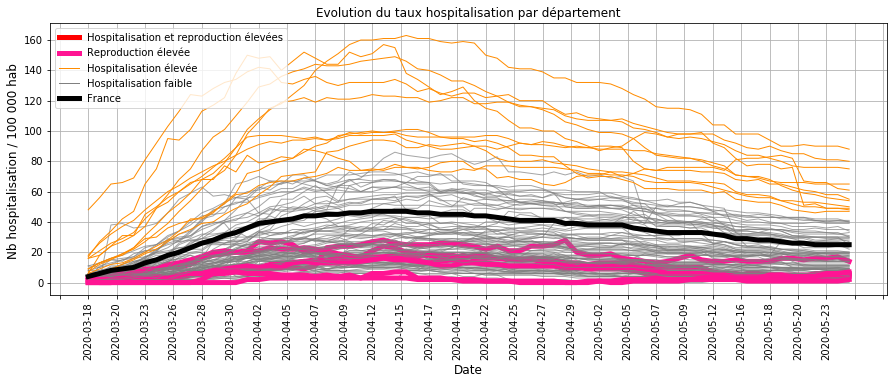

In [19]:
courbe_Thosp('France')

#### Commentaires :
- la majorité des départements (GRIS) sont proches ou en dessous de la moyenne nationale (NOIR),
- tous les départements dont le taux d'hospitaliation est élevé (ORANGE) ont une tendance à la baisse,
- les départements dont le taux de reproduction est elevé (ROSE) ont un taux d'hospitalisation faible.

Il n'apparait donc pas de département en forte croissance où les taux d'hospitalisation et de reproduction seraient élevés.

### Evolution des taux de reproduction

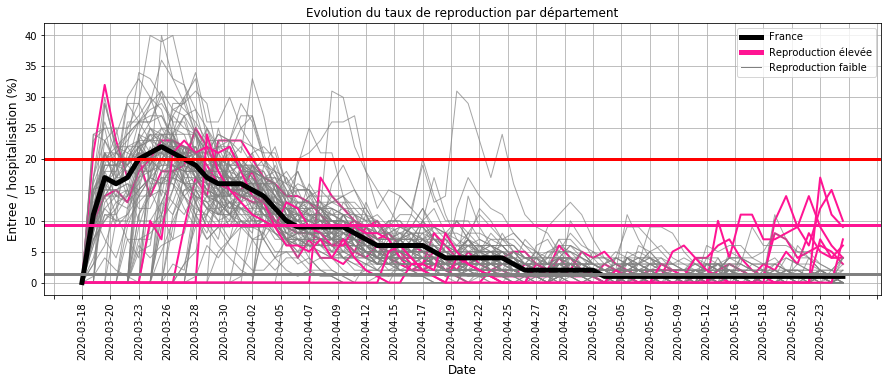

In [20]:
courbe_TEntree('France')

#### Commentaires :
- de mi-avril à mi-mai, le taux de reproduction était faible du à l'impact du confinement
- à partir du déconfinement, il y a quelques départements (ROSE) dont le taux de reproduction est reparti à la hausse (la limite correspond à 10 entrées quotidiennes pour 100 hospitalisations).

Ces derniers nécessitent une analyse plus détaillée.

### Evolution des taux d'hospitalisation élevés

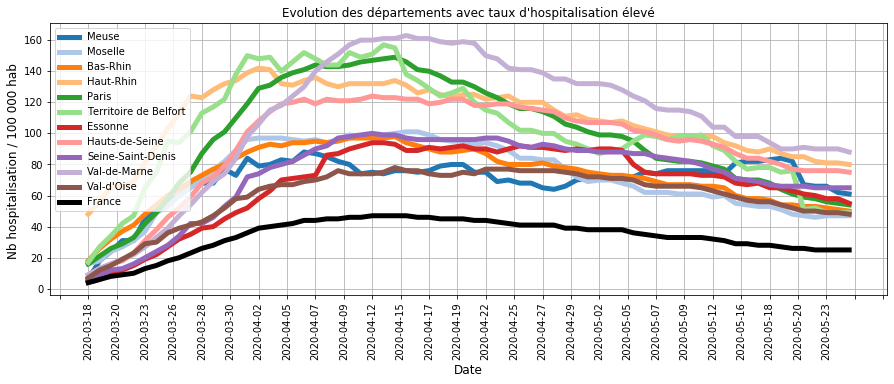

In [21]:
courbe_Thosphaut()

#### Commentaires : 
- La tendance des départements dont le taux d'hospitalisation est élevée est fortement à la baisse depuis quelques semaines
- Seule la Meuse (BLEU FONCE) dont la baisse est plus récente nécessite une surveillance dans les prochains jours.

### Evolution des taux de reproduction élevés

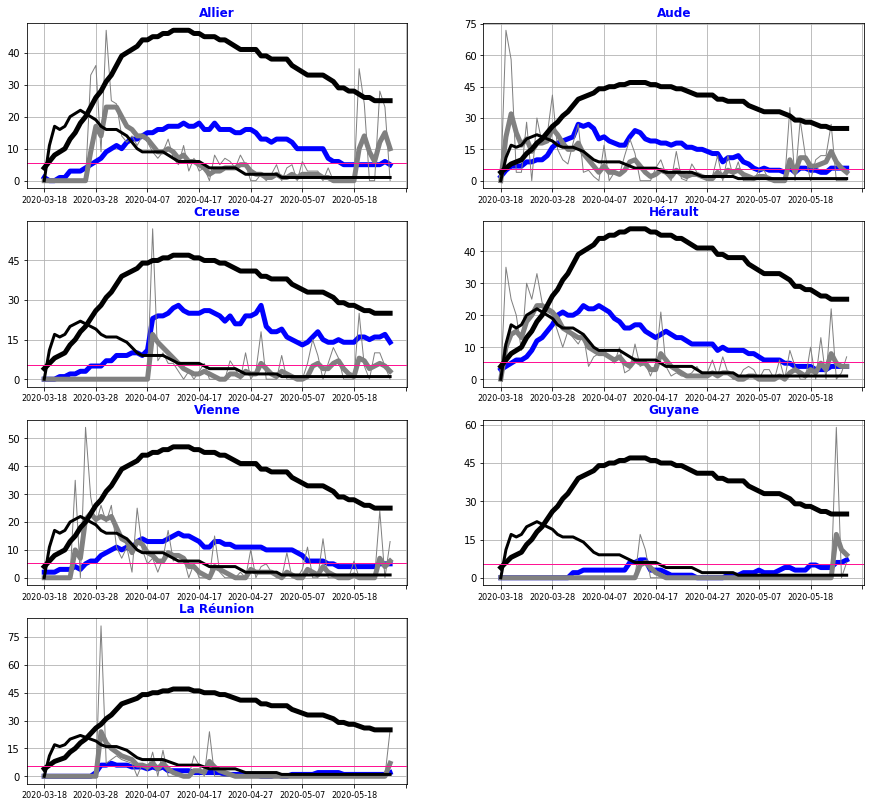

In [22]:
courbe_departement(Dj[(Dj['jour']== Dj['jour'].max()) & (Dj['alerte'] == True)]['DEP'].values)

#### Commentaires :
L'analyse des départements dont le taux de reproduction a augmenté ces derniers jours montre que :
- L'Aude et de la Creuse ont une tendance stable depuis 3 semaines,
- la Guyane a une tendance à la hausse,
- pour les 4 autres départements, il faut surveiller dans les prochains jours, si la tendance se confirme.

## Bilan sur la circulation du virus au 25 mai 2020 :
La majorité des départements ont une chute du nombre d'hospitalisation, ce qui traduit une faible circulation du virus.

Quelques exceptions :
- l'Aude et la Creuse dont le taux d'hospitalisation  stable depuis 3 semaines indique que la maîtrise de la circulation du virus est insuffisante,
- la Guyane dont la hausse constante des hospitalisations depuis 3 semaines indique une accélération de la circulation du virus.

Une surveillance de la tendance sur les prochains jours est nécessaire pour :
- La Meuse dont le taux d'hospitalisation est élevée et dont la chute est très récente,
- l'Allier, l'Hérault, la Vienne et la Réunion dont le taux d'hospitalisation est faible mais dont le taux de reprodution a récemment augmenté,

In [40]:
# Création d'un widget pour saisir un département 
def Synthese_departement(departement):
    courbe_departement([departement])
    return Dj.loc[Dj['DEP'] == departement,['jour','hosp','rad','dc','Entree','Sortie','Thosp','Treprod','Treprodmoy','CTreprod']].iloc[-14:]
#interact(Synthese_departement, departement = widgets.Dropdown(options= Dj[Dj['jour'] == Dj['jour'].max()]['DEP'],value='Puy-de-Dôme'))

In [25]:
## A faire

## Sauvegarde

In [3]:
## Sauvegarde des fichiers
# Sous Markdow : cela génère un sous repertoire avec les images
!jupyter nbconvert --to markdown --no-input  Surveillance_deconfinement_2020_05_25.ipynb
# Sous HTML
!jupyter nbconvert --to html --no-input  Surveillance_deconfinement_2020_05_25.ipynb

[NbConvertApp] Converting notebook Surveillance_deconfinement_2020_05_25.ipynb to markdown
[NbConvertApp] Support files will be in Surveillance_deconfinement_2020_05_25_files\
[NbConvertApp] Making directory Surveillance_deconfinement_2020_05_25_files
[NbConvertApp] Making directory Surveillance_deconfinement_2020_05_25_files
[NbConvertApp] Making directory Surveillance_deconfinement_2020_05_25_files
[NbConvertApp] Making directory Surveillance_deconfinement_2020_05_25_files
[NbConvertApp] Writing 3941 bytes to Surveillance_deconfinement_2020_05_25.md
[NbConvertApp] Converting notebook Surveillance_deconfinement_2020_05_25.ipynb to html
[NbConvertApp] Writing 1615023 bytes to Surveillance_deconfinement_2020_05_25.html
